# Estimate Cumulative absolute strain energy (CASE) with depth

This file provides an example of estimating the cumulative absolute change in strain energy down the depth of 
a soil profileaccording to Millen et al. (2019) and compares the results to linear site response analysis.

The estimate is performed using the base input motion, and then repeated using the surface motion.


### Load inline plotting and auto-reload commands

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pysra  # site response analysis package
import eqsig  # signal processing package
import sfsimodels as sm  # soil objects package

import liquepy as lq

# plotting
import matplotlib.pyplot as plt
from bwplot import cbox
import engformat as ef
plt.rcParams['savefig.dpi'] = 300

# Makes the plot edges white
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

## Define a function to run a site response analysis


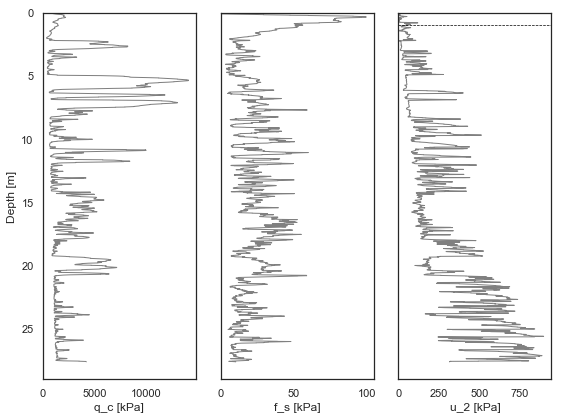

In [3]:
def run_sra(sp, m, odepths, analysis="linear", d_inc=None):
    """
    Conduct a site response analysis
    
    Parameters
    ----------
    sp: sm.SoilProfile object
    m: pysra.Motion object
    odepths: array_like
        Depths for outputting results
    analysis: str
        Analysis type (equivalent linear or linear)
    d_inc: float
        depth increment to discretize soil material behaviour

    Returns
    -------

    """
    if d_inc is None:
        d_inc = np.ones(sp.n_layers)

    profile = lq.sra.sm_profile_to_pysra(sp, d_inc=d_inc)
    if analysis == "linear":
        calc = pysra.propagation.LinearElasticCalculator()
    else:
        calc = pysra.propagation.EquivalentLinearCalculator()
    od = {}
    outs = []
    for i, depth in enumerate(odepths):
        od["upACCX_d%i" % i] = len(outs)
        outs.append(pysra.output.AccelerationTSOutput(pysra.output.OutputLocation('incoming_only', depth=depth)))
        od["ACCX_d%i" % i] = len(outs)
        outs.append(pysra.output.AccelerationTSOutput(pysra.output.OutputLocation('within', depth=depth)))
        od["STRS_d%i" % i] = len(outs)
        outs.append(pysra.output.StrainTSOutput(pysra.output.OutputLocation('within', depth=depth), in_percent=False))
        od["TAU_d%i" % i] = len(outs)
        outs.append(pysra.output.StressTSOutput(pysra.output.OutputLocation('within', depth=depth),
                                                normalized=False))

    outputs = pysra.output.OutputCollection(outs)

    # Perform the calculation
    calc(m, profile, profile.location('outcrop', depth=sp.height))
    outputs(calc)

    out_series = {}
    for item in od:
        if "TAU" in item:
            out_series[item] = outputs[od[item]].values
        else:
            out_series[item] = outputs[od[item]].values

    return out_series, profile, calc

## Define a function for obtaining CASE and CAKE from linear site response analysis


In [ ]:
def calc_case_and_cake_from_lin_analysis(sp, m):
    """
    Compute the CASE and CAKE from a linear analysis

    Parameters
    ----------
    sp: sm.SoilProfile object
    m: pysra.Motion object

    Returns
    -------

    """
    odepths = np.arange(0.5, int(sp.height - 1), 0.5)

    oseries, profile, calc = run_sra(sp, m, odepths)

    aew = []
    acc_uke = []
    up_uke = []
    down_uke = []

    for i, depth in enumerate(odepths):
        acc_signal = eqsig.AccSignal(oseries["ACCX_d%i" % i] * 9.8, m.time_step)
        g_mod = profile.location('outcrop', depth=depth).layer.initial_shear_mod
        rho = profile.location('outcrop', depth=depth).layer.unit_wt / 9.8

        tau = oseries["TAU_d%i" % i]
        strain_energy = 0.5 * tau ** 2 / g_mod

        delta_st_energy = np.diff(strain_energy)
        delta_st_energy = np.insert(delta_st_energy, 0, 0)
        cum_delta_st_energy = np.cumsum(abs(delta_st_energy))

        up_acc_signal = eqsig.AccSignal(oseries["upACCX_d%i" % i] * 9.8, m.time_step)
        down_acc_signal = eqsig.AccSignal((oseries["upACCX_d%i" % i] - oseries["ACCX_d%i" % i]) * 9.8, m.time_step)

        acc_uke.append(eqsig.im.calc_unit_kinetic_energy(acc_signal)[-1] * rho)
        up_uke.append(eqsig.im.calc_unit_kinetic_energy(up_acc_signal)[-1] * rho)
        down_uke.append(eqsig.im.calc_unit_kinetic_energy(down_acc_signal)[-1] * rho)

        aew.append(cum_delta_st_energy[-1])

    cake = np.array(aew)
    case = np.array(acc_uke)

    return odepths, case, cake


## Compute the LSN number

van Ballegooy, S., Wentz, F., & Boulanger, R. W. (2015). Evaluation of a CPT-based liquefaction procedure at regional scale. Soil Dynamics and Earthquake Engineering, 1–20. http://doi.org/10.1016/j.soildyn.2015.09.016

In [5]:
epsilon = lq.trigger.calculate_volumetric_strain(bi2014.factor_of_safety, bi2014.q_c1n_cs)
lsn = lq.trigger.calculate_lsn(epsilon, cpt.depth)
print("LSN: {0:.2f}".format(lsn))


LSN: 25.16


References:

 - Millen, M. D. L., Rios, S., Quintero, J., & Viana Da Fonseca, A. (2019). Prediction of time of liquefaction using kinetic and strain energy. Soil Dynamics and Earthquake Engineering, 105898. http://doi.org/10.1016/j.soildyn.2019.105898